In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import logging

In [2]:
LogFormatter = logging.Formatter("%(asctime)s '%(name)-10s' : [%(levelname)8s] %(message)s")# (ln : %(lineno)4s)")

In [378]:
class IsingModel:
    """Ising model simulation class.

    Parameters
    ----------
    L : integer
        The system size as integer.
    T : float or array (optional)
        Temperature(s) where you want to simulate(Default = 1).
    H : float or array (optional)
        Intensity of external magnetic field (Defalut = 0).
        
    initial configuration is disordered state. If you want to turn to ordered, use 'set_ordered()'.

    """
    
    
    def __init__(self, L, random_field = False, seed = None, **kwarg):
        D = 2
        self.size = np.power(L,D)
        self.L = L
        self.D = D
        self.H, self.T = None, None
        self.random_field = random_field
        #if not kwarg:
        #    kwarg['t'] = 1
        if not seed is None:
            np.random.seed(seed)
        self.logger = logging.getLogger("ising")
        self.logger.setLevel(logging.DEBUG)
        if not self.logger.handlers:
            stream = logging.StreamHandler()
            stream.setFormatter(LogFormatter)
            self.logger.addHandler(stream)
        self.logger.info("system start")
        self.algorithm = {}
        for metro in ['M',"metropolis","Metropolis", "m", 'metro']:
            self.algorithm[metro] = self.Metropolis
        for wo in ['W','Wolff','w','wolff']:
            self.algorithm[wo] = self.Wolff
        self.set_parameter(**kwarg)
        self.initialize()
        
    def set_parameter(self,**kwarg):
        """Setting parameters of Ising model.
        
        Parameters
        ----------
            T : float or array (optional)
                Temperature(s) where you want to simulate(Default = 1).
            H : float or array (optional)
                Intensity of external magnetic field (Defalut = 0).
        """
        logger = self.logger.getChild("set_param")
        logger.setLevel(logging.INFO)
        
        #initializing of parameters
        if self.H is None:
            self.H = 0
        if self.T is None:
            self.T = 1
        
        
        #parameter parsing
        for param in kwarg:
            if param.lower() == 'h':
                self.H = kwarg[param]
                logger.debug("H set as : {}".format(self.H))
            elif param.lower() == 't':
                self.T = kwarg[param]
                logger.debug("T  set as : {}".format(self.T))
        
        #pre calculate boltzmann factor
        self.metropolis = np.empty([5,2]) #nn up, spin up-down
        
        DeltaE = 2*((2*np.arange(5)-4)+self.H) #DeltaE/spin  spin_down - spin_up
        
        if self.T == 0:
            self.metropolis.T[0][DeltaE>0] = 0  #exp(-beta*DeltaE) = exp(-beta(2(J*nn_sum*spins + H*spins)))
            self.metropolis.T[0][DeltaE<=0] = 1   #nn_sum = 4(=nn) - 2*nUp 
            self.metropolis.T[1][DeltaE>=0] = 1
            self.metropolis.T[1][DeltaE<0] = 0
            self.wolff_p = 1 
        else:
            self.metropolis.T[0] = np.exp(-DeltaE/self.T)
            self.metropolis.T[1] = np.exp(DeltaE/self.T)
            self.wolff_p = 1 - np.exp(-2/self.T)
        
        
        #boltzmann_factor()
        
    def initialize(self):
        logger = self.logger.getChild("Init")
        logger.setLevel(logging.INFO)
        #spin site allocation
        size= [self.L for i in range(self.D)]
        self.spins = 2*np.random.randint(0,2, size=size) -1
        self.energy = 0
        self.magnetization = self.spins.sum()
        J = 1
        for i in range(self.size):
            logger.debug("Number : {}".format(i))
            point = (int(i/self.L), i%self.L)
            logger.debug("Point : {}".format(point))
            logger.debug("Spin State : {}".format(self.spins[point]))
            logger.debug("Nearest neighbor : {}".format(self.spins[self.nn(*point)]))
            energy = - (J * self.spins[self.nn(*point)]*self.spins[point]).sum()
            logger.debug("Energy : {}".format(energy))
            self.energy += energy
        self.energy*=1/2
        self.energy-= (self.spins*self.H).sum()
    
    def set_ordered(self, up = True):
        """
        if up is true, all spins will be up-spin. otherwise, down-spin.
        """
        size= [self.L for i in range(self.D)]
        self.energy = -2*self.size
        if up:
            self.magnetization = self.size
        else:
            self.magnetization = -self.size
        self.spins = int(self.magnetization/self.size)*np.ones(size)
        self.energy -= (self.spins*self.H).sum()
            
    
    def nn(self, i,j): #critical : only for 2 Dimension (Down,Right,Up,Left)
        return np.array([(i+1)%self.L,i,i-1,i]), np.array([j,(j+1)%self.L,j,j-1])
    
    def Wolff(self,i,p): #single Wolff self.H will be ignored.
        logger = self.logger.getChild("Wolff")
        point = lambda i: (int(i/self.L), i%self.L)
        direction = self.spins[point(i)]
        self.spins[point(i)] *= -1
        boundary = [point for point in self.nn(*point(i)).T]
        while boundary:
            target = boundary.pop()
            if self.spins[target] != direction: 
                self.energy-=2
                continue
            if p<self.wolff_p:
                self.spins[*target] = -direction
                for point in self.nn(*point(i)).T:
                    boundary.append(point)
        
    
    def Metropolis(self,i,p): #single metropolis
        """Single Metropolis algorithm.
        
        Parameter
        ------------
        i : integer(<system size)
            i-th spin site (target)
        p : float 
            prepared uniform random variable for fast computing
            
        
        Update single spin.
        """
        #nn_sum = 2*nUp - 4(=nn)
        #assert i <= self.size, "index out of range"
        #logger = self.logger.getChild("Metro.Al.")
        #logger.setLevel(logging.INFO)
        #logger.debug("input  : {}".format(i))
        point = (int(i/self.L), i%self.L)
        #logger.debug("Point  : {} with L = {}".format(point, self.L))
        spin = self.spins[point]
        nUp = int(-(self.spins[self.nn(*point)].sum()-4)/2)
        #logger.debug("spin   : {}, nearest neighbor = {}, nUp = {}".format(spin, self.spins[self.nn(*point)],nUp))
        #logger.debug("Delta E: {}(probability), p = {}".format(self.metropolis[nUp,int((spin+1)/2)], p))
        if p<self.metropolis[nUp,int((spin+1)/2)]:
            self.magnetization -= spin*2
            self.energy -= 2*(2*nUp-4+self.H)*spin
            self.spins[point] *= -1
            #logger.debug("Fliped.")
            return 
        #else:
            #logger.debug("Nope.")
        #return
        
    def plot(self):
        plt.figure(figsize = [4,4])
        plt.axis('off')
        for i in range(self.L):
            for j in range(self.L):
                if self.spins[i,j] == 1:
                    plt.scatter(i,j,c='blue',s = (np.sqrt(20000)/self.L)**2)
                else:
                    plt.scatter(i,j,c='red',s = (np.sqrt(20000)/self.L)**2)
        
    def loc(self):
        return vars(self)
        
    def __del__(self):
        del self.logger
        

SyntaxError: invalid syntax (<ipython-input-378-63a04baf7805>, line 142)

In [4]:
class Simulator:
    def __init__(self, model, file):
        self.model = model
        self.file = h5py.File(file)
        
    def Range(self, **kwarg):#simulation range for static simulation
        self.T = [1]
        self.H = [0]
        for param in kwarg:
            if param.lower() == 'h':
                self.H = kwarg[param]
                #logger.debug("H set as : {}".format(self.H))
            elif param.lower() == 't':
                self.T = kwarg[param]
                #logger.debug("T  set as : {}".format(self.T))
    
    def calculate(self,algorithm, MCS): #simulate and record calculation at specific coefficient T, H
        for h in self.H:
            for t in self.T:
                param = self.file.require_group('{},{}'.format(t,h))
                alg = param.require_group(self.model.algorithm[algorithm].__name__)
                saver = alg.require_group('disorder')
                self.model.set_parameter(t=t,h=h)
                self.model.initialize()
                m,ms, e,es,eq = np.empty([5,MCS],dtype = np.float64)
                for step in range(MCS):
                    target = np.random.randint(0,self.model.size, size = [self.model.size])
                    prob = np.random.random([self.model.size])
                    for i,p in zip(target, prob):
                        self.model.algorithm[algorithm](i,p)
                    m[step] = self.model.magnetization
                    ms[step] = (self.model.magnetization**2)
                    e[step] = self.model.energy
                    es[step] = self.model.energy ** 2
                    eq[step] = self.model.energy ** 4
                saver.create_dataset('m', data = m)
                saver.create_dataset('ms', data = ms)
                saver.create_dataset('e', data = e)
                saver.create_dataset('es', data = es)
                saver.create_dataset('eq', data = eq)
                
                saver = alg.require_group('order')
                self.model.set_ordered()
                m,ms, e,es,eq = np.empty([5,MCS],dtype = np.float64)
                for step in range(MCS):
                    target = np.random.randint(0,self.model.size, size = [self.model.size])
                    prob = np.random.random([self.model.size])
                    for i,p in zip(target, prob):
                        self.model.algorithm[algorithm](i,p)
                    m[step] = self.model.magnetization
                    ms[step] = (self.model.magnetization**2)
                    e[step] = self.model.energy
                    es[step] = self.model.energy ** 2
                    eq[step] = self.model.energy ** 4
                saver.create_dataset('m', data = m)
                saver.create_dataset('ms', data = ms)
                saver.create_dataset('e', data = e)
                saver.create_dataset('es', data = es)
                saver.create_dataset('eq', data = eq)
        
    def equilibrate(self, algorithm, T,H = 0, MCS = 100):
        self.model.set_parameter(t=T, H=H)
        for _ in range(MCS):
            target = np.random.randint(0,self.model.size, size = [self.model.size])
            prob = np.random.random([self.model.size])
            for t,p in zip(target, prob):
                self.model.algorithm[algorithm](t,p)
                
    def plot(self):
        plt.imshow(a.spins)
        plt.axis("off")
    
    def dynamic_demo(self, t_range, algorithm, **kwarg):
        self.H, self.T, mcs = None, None, 1
        keep_demo = False
        for param in kwarg:
            if param.lower() == 'h':
                self.H = kwarg[param]
                #logger.debug("H set as : {}".format(self.H))
            
                #logger.debug("T  set as : {}".format(self.T))
            elif param.lower() == 'mcs':
                mcs = kwarg[param]
            elif param == 'keep_demo':
                keep_demo = kwarg[param]
                
        self.T = t_range
        
        if self.H is None:
            self.H = np.zeros([len(self.T)])
            
        
        #method = vars(self.model)[algorithm]
        for t,h in zip(self.T, self.H):
            self.model.set_parameter(t=t, h=h)
            
            for _ in range(mcs):
                target = np.random.randint(0,self.model.size, size = [self.model.size])
                prob = np.random.random([self.model.size])
                for i,p in zip(target,prob):
                    self.model.algorithm[algorithm](i, p)
                plt.text(0,-1, "T = {:.3}, H = {:.3}".format(t,h))
                
                plt.imshow(self.model.spins,vmin= -1, vmax =1 )
                plt.axis("off")
                clear_output(wait=True)
                plt.pause(0.01)
                
        if keep_demo:
            while True:
                target = np.random.randint(0,self.model.size, size = [self.model.size])
                prob = np.random.random([self.model.size])
                for i,p in zip(target,prob):
                    self.model.algorithm[algorithm](i, p)
                plt.text(0,-1, "Keepshowing")
                
                plt.imshow(self.model.spins,vmin= -1, vmax =1 )
                plt.axis("off")
                clear_output(wait=True)
                plt.pause(0.01)

# Exercise of "Entropy, Order Parameters, and Complexity" 

## Chap. 8 Computation and Calculation (Monte-Carlo Simulation)

> In this page, I will give some codes and solution of exercise of chapter 8.

<br><br><br>
<p style="text-align: right;">- Jung Hoon Jung</p>

## Prologue

### Ising model

The *Ising model* :  

   - the continuous and abrupt phase transitions in the model as temperature and field are varied. 

*Ising fluctuations and susceptibilities* :  

   - the linear response of the model to external ﬁelds, the connection between fluctuations and response, and the energy gap and Curie law at low and high temperatures. 

### Monte-Carlo algorithms

*Coin flips and Markov chains* and *Red and green bacteria* :  

- examples of non-equilibrium Markov chains. 

*Detailed balance* :  

- derives a formulation of this basic transition rate relation that does not presume an equilibrium probability distribution. 

*Metropolis* :  

- the most commonly applied Monte Carlo method.

### Monte-Carlo algorithms (continued)

*Implementing Ising* :  

- you write your own heat-bath and Metropolis algorithms. 

*Wolff* and *Implementing Wolff* :  

- analysis a powerful and subtle cluster-flip algorithm. 

### Small systems

*Stochastic cells* and *The repressilator* :  

- develop Monte Carlo methods (the Gillespie algorithm) for stochastic simulations of chemical reactions in these systems. 

*Entropy increases! Markov chains* :  

- You show that the coarse-grained description of a system with a Markov chain does decrease the free energy with time.

### And so on

*Hysteresis and avalanches* :  

- we introduce a nonequilibrium lattice model describing magnets.

*Hysteresis algorithms* :  

- we explore a modern O(N logN) algorithm for evolving the model. 

*NP-completeness and satisfiability* :  

- we explore the most challenging class of problems in computer science, 
and find a phase transition at which the truly difficult cases congregate. 

Totally, 15 problem exists.

## Outline

Contents :  

 - Introduction
 - Model
 - pseudo code
 - result

## Exercise 8.1, 8.2, 8.6, 8.7, 8.8, 8.9 The Ising model

### Introduction

Goal :  

- Making a two-dimensional square-lattice Ising model simulation
- Implementing two famous algorithm : Metropolis, Wolff
- Analyzing the Ising model based on fluctuation and phase transition

In this exercise, we make square-lattice Ising model which is famous practice for Monte-Carlo simulation

####  Schematic of Ising model

![Ising spins](image/ising.png)

### Hamiltonian

The Ising model's Hamiltonian is following :

$$\mathcal{H} = -J\sum_{\langle i,j\rangle} S_iS_j - H \sum_i S_i,$$

where $S_i=  \pm 1$ are 'spins' on a square lattice, and the sum $\sum_{\langle i,j \rangle}$ is over the four nearestneighbor bonds (each pair summed once).

### Variables and Setup

It is conventional to set the coupling strength $J = 1$ and Boltzmann's constant $k_B = 1$, 
which amounts to measuring energies and temperatures in units of $J$.

The constant $H$ is called the external (magnetic) field, and $M=\sum_i S_i$ is called the magnetization.

### 8.2 Ising fluctuations and susceptibilities

The partition function for the Ising model is $Z = \sum_n \exp(-\beta E_n)$, and the free energy $F=-kT\log{Z}$.

(a) 
>Show that the average of the magnetization $M$ equals $-(\partial F/\partial H)|_T$.  
 Derive the formula for the susceptibility $\chi_0 = (\partial M/\partial H)|_T$ in terms of $\langle(M-\langle M\rangle)^2\rangle = \langle M^2\rangle - \langle M\rangle^2$

$
\begin{aligned}
-\left. \frac{\partial F}{\partial H}\right|_T &= -\left. \frac{\partial }{\partial H}\left( -kT \log Z\right) \right|_T \\
&= \frac{kT}{Z}\frac{\partial Z}{\partial H} \\
\end{aligned}
$

$
\begin{aligned}
\frac{1}{Z}\frac{\partial Z}{\partial H} &= \frac{1}{Z}\frac{\partial}{\partial H} \sum_n \exp(-\beta \mathcal{H})\\
&=\frac{1}{Z}\frac{\partial}{\partial H} \sum_n \exp \left(-\beta \left( -J\sum_{\langle i,j\rangle} S_iS_j - H \sum_i S_i \right) \right) \\
&=\frac{1}{Z}\sum_n \beta \left( \sum_i S_i \right)\exp \left(-\beta \left( -J\sum_{\langle i,j\rangle} S_iS_j - H \sum_i S_i \right) \right) = \frac{1}{kT}\sum_n  M P(E_n) = \frac{1}{kT} \langle M \rangle
\end{aligned}
$

Finally,  
  
  
$
\begin{aligned}
-\left. \frac{\partial F}{\partial H}\right|_T &= -\left. \frac{\partial }{\partial H}\left( -kT \log Z\right) \right|_T \\
&= \frac{kT}{Z}\frac{\partial Z}{\partial H} = \sum_n  M P(E_n) = \langle M \rangle \\
\end{aligned}
$  

Similarly,  
  
$
\begin{aligned}
\left. \frac{\partial M}{\partial H}\right|_T &= -\left. \frac{\partial^2 }{\partial H^2}\left( -kT \log Z\right) \right|_T 
= \left(\frac{kTZ'}{Z}\right)' \quad \quad \left({}' \equiv \frac{\partial }{\partial H}\right)\\
&= kT\left(\frac{Z''}{Z}- \left(\frac{Z'}{Z}\right)^2\right)= \frac{1}{kT}\left(\langle M^2\rangle - \langle M\rangle^2\right)\\
\end{aligned}
$  

(b)
> Check the formula for $C$ and $\chi$ from part (a) at $H = 0$ and $T = 3$, by measuring the ﬂuctuations and the averages, and then changing by $\Delta H = 0.02$ or $\Delta T = 0.1$ and measuring the averages again. Check them also for $T = 2$, where $\langle M \rangle \neq 0$.

We will see the calculation predict (or not) the result of computation. Let's try another observable.  

#### Low-temperature expansion for the magnetization.

(c)
> What is the energy for flipping a spin antiparallel to its neighbors? Equilibrate at a relatively low temperature $T = 1.0$, and measure the magnetization. Notice that the primary excitations are single spin flips. In the low-temperature approximation that the flipped spins are dilute, write a formula for the magnetization.

When the spin flips to antiparallel to its neighbors, because of low temperature, that spin has to break the 4 bonds.  
For convenience, whole spins face to direction of external field $H$ and set as positive ($\forall S_i = 1$).

![lat](image/lat.png)

Local energy of $i$-th spin $\epsilon_i$ is below, 
$$\epsilon_i  = -J\cdot(\mathrm{number\,of\,bond})+ H $$

![flip](image/flip.png)

If the spin flips, the local energy will be change as follow,
$$\epsilon_i  = J\cdot(\mathrm{number\,of\,bond})+ H $$

So, $\Delta \epsilon = 2J\cdot(\mathrm{number\,of\,bond})+ H$

The magnetization is approaximately,
$$ M(\beta) \approx \frac{1}{\mathcal{N}} \sum_{n_\downarrow=0}^{N} (N-2n_\downarrow)g(n_\downarrow)e^{-\beta(E_g +\Delta e \cdot n_\downarrow)} \quad (\mathcal{N} = \sum_{n_\downarrow=0}^N g(n_\downarrow) e^{-\beta(E_g+\Delta e \cdot n_\downarrow)}$$

$$\begin{align}
M(\beta) &\approx \frac{1}{\mathcal{N}} \sum_{n_\downarrow=0}^{N} N g(n_\downarrow)e^{-\beta(E_g +\Delta e \cdot n_\downarrow)}  
- \frac{1}{\mathcal{N}}\sum_{n_\downarrow=0}^{N} 2n_\downarrow g(n_\downarrow)e^{-\beta(E_g +\Delta e \cdot n_\downarrow)} \\ 
&= N - \frac{1}{\mathcal{N}}\sum_{n_\downarrow=0}^{N} 2n_\downarrow g(n_\downarrow)e^{-\beta(E_g +\Delta e \cdot n_\downarrow)}
\end{align}
$$

$$\begin{align}
m(\beta) = \frac{M(\beta)}{N} &\approx 1
- \frac{1}{\mathcal{N}}\sum_{n_\downarrow=0}^{N} 2n_\downarrow \frac{g(n_\downarrow)}{N}e^{-\beta(E_g +\Delta e \cdot n_\downarrow)} \\ 
&\sim 1 - \sum_{n_\downarrow=0}^{N} 2n_\downarrow g_1(n_\downarrow)e^{-\beta(\Delta e \cdot n_\downarrow)} \quad (where \quad 
g_1(n_\downarrow) = g(n_\downarrow)/N )
\end{align}
$$

$$\begin{align}
m = &1−2x^6 −12x^10 + 14x^12 −90x^14 + 192x^16 −792x^18 + 2148x^20 \\
&−7716x^22 + 23262x^24 −79512x^26 + 252054x^28 −846628x^30 \\
&+ 2753520x^32−9205800x^34 + 30371124x^36−101585544x^38+ \dots \end{align}$$  
(3 Dimensional ising model expansion in text-book) ($x = e^{-2J/k_BT}$)

#### High-temperature expansion for the susceptibility.



At high temperatures, we can ignore the coupling to the neighboring spins.

(d)
> Calculate a formula for the susceptibility of a free spin coupled to an external ﬁeld. Compare it to the susceptibility you measure at high temperature T = 100 for the Ising model.

The partition function of a free spin coupled to an external field is,  

$$Z = (2\cosh{\beta H})^N(/N!)$$

$$M = \frac{1}{\beta}\frac{\partial \ln Z}{\partial H} = \tanh \beta H $$

$$\chi = \frac{\partial M}{\partial H} = (\tanh \beta H)' \approx \beta H \propto \frac{H}{T}$$

(Curie's law)

### Demo of Metropolis

In [359]:
sim = Simulator(IsingModel(80),'test')

2019-12-18 12:24:57,407 'ising     ' : [    INFO] system start


In [360]:
sim.equilibrate('M', T = 0)

KeyboardInterrupt: 

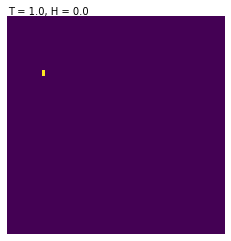

In [362]:
sim.dynamic_demo([1.],'Metropolis',MCS = 1000)

## Exercise 8.3, 8.4, 8.12 Markov chain. (coin flip and bacteria growth)

### Introduction

#### Coin flips

(a)  
> Treat the  two states of the physicist ('still flipping' and 'done') as states in a Markov chain. The current probability vector then is $\vec \rho = \begin{pmatrix} \rho_{flipping} \\ \rho_{done} \end{pmatrix}$. Write the transition matrix $\mathcal{P}$, giving the time evolution $\mathcal{P}\cdot\vec \rho_{n} =\vec \rho_{n+1}$, assuming that the coin is fair. 

$$\rho_{flipping}' = \frac{1}{2}\rho_{flipping} \\
\rho_{done}'    = \frac{1}{2}\rho_{flipping} + \rho_{done}$$

$$\rho_{flipping}' = \frac{1}{2}\rho_{flipping}+0\cdot\rho_{done} \\
\rho_{done}'    = \frac{1}{2}\rho_{flipping} + \rho_{done}$$

$$\mathcal{P} = \begin{pmatrix} \frac{1}{2} & 0 \\ \frac{1}{2} & 1 \end{pmatrix} $$

(b)
> Find the eigenvalues and right eigenvectors of $\mathcal{P}$. Which eigenvector is the steady state $\rho^*$? Call the other eigenvector $\widetilde\rho$. For convenience, normalize $\widetilde\rho $ so that its first component equals one. 

With some insight, one can write down $\rho^*$ as following,  

$$
\rho^* = \begin{pmatrix} 0 \\ 1 \end{pmatrix} \rightarrow \mathcal{P}\cdot\rho^* = 1\cdot\rho^*
$$

Now, to get  $\,\widetilde\rho$,
$$\mathcal{P}\rho^* = \lambda\rho^* \\ 
(\mathcal{P} - \lambda)\rho^* = 0$$

$$\begin{vmatrix} \frac{1}{2}-\lambda & 0 \\ \frac{1}{2} & 1 -\lambda\end{vmatrix} = 0 \rightarrow \lambda = \frac{1}{2}, 1$$

$$\frac{1}{2}\cdot 1 + 1\cdot\widetilde\rho_1 = \frac{1}{2}\widetilde\rho_1 \quad (\,\because\widetilde\rho_0 = 1\,) \quad \rightarrow\quad
\rho_1 = -1\\ \therefore \widetilde \rho =  \begin{pmatrix} 1 \\ -1 \end{pmatrix}$$

(c)
> Assume an arbitrary initial state is written $\rho_0 = A\rho^* + B\widetilde\rho$. What are the conditions on A and B needed to make $\rho_0$ a valid probability distribution? Write $\rho_n$ as a function of A, B, $\rho^*$, and $\widetilde\rho $.

The component of $\rho_0$ must be in $[0,1]$,  

$$0\leq \rho_i \leq 1 \rightarrow 0\leq B\leq A \leq 1$$


$$\rho_0 = A\rho^* + B\widetilde\rho \\
\rho_n=\mathcal{P}^n\rho_0 = \mathcal{P}^n(A\rho^* + B\widetilde\rho) = A\rho^* + B\left(\frac{1}{2}\right)^n\widetilde\rho
$$

#### Red and green bacteria

A growth medium at time $t = 0$ has 500 red bacteria and 500 green bacteria. Each hour, each bacterium divides in two. A color-blind predator eats exactly 1000 bacteria per hour

(a)
>After a very long time, what is the probability distribution for the number $\alpha$ of red bacteria in the growth medium?

Set one of bacterium divides in two, A color-blind predator eats only 1 bacteria repeat a thousand times per hour, let Number of red-bacteria as $\alpha$,

| Divide\Eat          | $\alpha$                              | $N - \alpha$                               |
|--------------|---------------------------------------|--------------------------------------------|
| $\alpha$     | $\frac{\alpha}{N}\frac{\alpha+1}{N+1}$| $\frac{\alpha}{N}\frac{N-\alpha}{N+1}$     |
| $N - \alpha$ | $\frac{N-\alpha}{N}\frac{\alpha}{N+1}$| $\frac{N-\alpha}{N}\frac{N+1 - \alpha}{N+1}$ |

$$\alpha \rightarrow \alpha +1 : (\alpha, N - \alpha) = \frac{\alpha}{N}\frac{N-\alpha}{N+1} \\
\alpha \rightarrow \alpha  : (\alpha, \alpha) + (N - \alpha, N - \alpha) = \frac{\alpha}{N}\frac{\alpha+1}{N+1} + \frac{N+1-\alpha}{N}\frac{N - \alpha}{N+1} \\
\alpha \rightarrow \alpha -1 : (N-\alpha, \alpha) = \frac{N-\alpha}{N}\frac{\alpha}{N+1}
$$

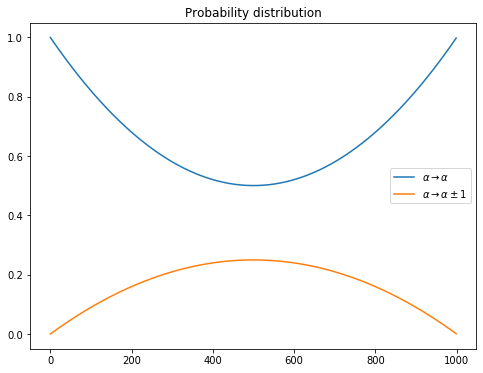

In [376]:
plt.figure(figsize =[8,6])
alpha =np.arange(0,1000)
plt.plot(alpha,((alpha+1)*alpha+(1000+1-alpha)*(1000-alpha))/(1000*1001), label = r'$\alpha \rightarrow \alpha$')
plt.plot(alpha, (-alpha**2+1000*alpha)/1000/1001, label = r'$\alpha \rightarrow \alpha \pm 1$')
plt.title("Probability distribution")
plt.legend()

(b)
> Roughly how long will it take to reach this final state?

When $\alpha = \frac{1}{2}N$, 

| Probability    | $\alpha-1$    | $\alpha$      | $\alpha+1$    |
|----------------|---------------|---------------|---------------|
| $\alpha(=1/2)$ | 1 / 4 | 1 / 2 | 1 / 4 |
| $\alpha(=0)$   | 0             | 1             | 0             |

(c)
> Assume that the predator has a 1% preference for green bacteria (implemented as you choose). Roughly how much will this change the final distribution?

## Exercise 8.3, 8.4, 8.12 Detailed balance.

In an equilibrium system, for any two states $\alpha$ and $\beta$ with equilibrium probabilities $\rho^*_\alpha$ and $\rho^*_\beta$, detailed balance states that  

$$P_{\beta\leftarrow\alpha}\rho^*_\alpha = P_{\alpha\leftarrow\beta}\rho^*_\beta $$  

that is, the equilibrium flux of probability from $\alpha$ to $\beta$ is the same as the flux backward from $\beta$ to $\alpha$. It is both possible and elegant to reformulate the condition for detailed balance so that it does not involve the equilibrium probabilities. Consider three states of the system, $\alpha$, $\beta$, and $\gamma$. 

(a)
> Assume that each of the three types of transitions among the three states satisfies detailed balance. Eliminate the equilibrium probability densities to derive
$$P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}P_{\gamma\leftarrow\alpha} = P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta}P_{\beta\leftarrow\alpha}$$


With equilibrium probabilities $\rho^*_\alpha$, given equation is,

$$P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}P_{\gamma\leftarrow\alpha} \rho^*_\alpha= P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta}P_{\beta\leftarrow\alpha}\rho^*_\alpha$$

For left hand side, 

$$\begin{align}
P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}P_{\gamma\leftarrow\alpha} \rho^*_\alpha &= P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}\left(P_{\alpha\leftarrow\gamma} \rho^*_\gamma \right) &= P_{\alpha\leftarrow\beta}P_{\alpha\leftarrow\gamma}\left( P_{\beta\leftarrow\gamma} \rho^*_\gamma \right) \\
&= P_{\alpha\leftarrow\beta}P_{\alpha\leftarrow\gamma}\left( P_{\gamma\leftarrow\beta} \rho^*_\beta \right) &= P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta}\left( P_{\alpha\leftarrow\beta} \rho^*_\beta \right) \\
&= P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta} P_{\beta\leftarrow\alpha} \rho^*_\alpha 
\end{align}
$$

$$\left( P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}P_{\gamma\leftarrow\alpha} - P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta} P_{\beta\leftarrow\alpha}\right) \rho^*_\alpha  = 0$$

$$\rho^*_\alpha  \neq 0, \quad \rightarrow \quad P_{\alpha\leftarrow\beta}P_{\beta\leftarrow\gamma}P_{\gamma\leftarrow\alpha} = P_{\alpha\leftarrow\gamma}P_{\gamma\leftarrow\beta}P_{\beta\leftarrow\alpha}$$

It is possible to show conversely that if every triple of states in a Markov chain satisﬁes the condition 8.22 then it satisﬁes detailed balance (that there is at least one probability density ρ∗ which makes the probability ﬂuxes between all pairs of states equal), except for complications arising when some of the rates are zero. 

# Q & A

In [118]:
files = [h5py.File('../../../../ising/test_{}.hdf5'.format(i+1))for i in range(11)]

In [185]:
zeros = [h5py.File('../../../../ising/test_{}.hdf5'.format(16*2**(i)))for i in range(3)]

In [178]:
T,H = [],[]
dm, dms, de, des, deq = {},{},{},{},{}
om, oms, oe, oes, oeq = {},{},{},{},{}
for key in zeros[0]['16']:
    t,h = key.split(",")
    t,h = np.array([t,h], np.float64)
    T.append(t)
    H.append(h)
    dm[t] = zeros[0]['16'][key]['Metropolis/disorder']['m'][:]
    dms[t] = zeros[0]['16'][key]['Metropolis/disorder']['ms'][:]
    de[t] = zeros[0]['16'][key]['Metropolis/disorder']['e'][:]
    des[t] = zeros[0]['16'][key]['Metropolis/disorder']['es'][:]
    deq[t] = zeros[0]['16'][key]['Metropolis/disorder']['eq'][:]
    om[t] = zeros[0]['16'][key]['Metropolis/order']['m'][:]
    oms[t] = zeros[0]['16'][key]['Metropolis/order']['ms'][:]
    oe[t] = zeros[0]['16'][key]['Metropolis/order']['e'][:]
    oes[t] = zeros[0]['16'][key]['Metropolis/order']['es'][:]
    oeq[t] = zeros[0]['16'][key]['Metropolis/order']['eq'][:]
    

In [179]:
for file in files:
    for key in file['16']:
        t,h = key.split(",")
        t,h = np.array([t,h], np.float64)
        T.append(t)
        H.append(h)
        dm[t] = file['16'][key]['Metropolis/disorder']['m'][:]
        dms[t] = file['16'][key]['Metropolis/disorder']['ms'][:]
        de[t] = file['16'][key]['Metropolis/disorder']['e'][:]
        des[t] = file['16'][key]['Metropolis/disorder']['es'][:]
        deq[t] = file['16'][key]['Metropolis/disorder']['eq'][:]
        om[t] = file['16'][key]['Metropolis/order']['m'][:]
        oms[t] = file['16'][key]['Metropolis/order']['ms'][:]
        oe[t] = file['16'][key]['Metropolis/order']['e'][:]
        oes[t] = file['16'][key]['Metropolis/order']['es'][:]
        oeq[t] = file['16'][key]['Metropolis/order']['eq'][:]


In [215]:
T,H = [],[]
dm, dms, de, des, deq = {},{},{},{},{}
om, oms, oe, oes, oeq = {},{},{},{},{}
for key in zeros[1]['32']:
    t,h = key.split(",")
    t,h = np.array([t,h], np.float64)
    T.append(t)
    H.append(h)
    dm[t] = zeros[1]['32'][key]['Metropolis/disorder']['m'][:]
    dms[t] = zeros[1]['32'][key]['Metropolis/disorder']['ms'][:]
    de[t] = zeros[1]['32'][key]['Metropolis/disorder']['e'][:]
    des[t] = zeros[1]['32'][key]['Metropolis/disorder']['es'][:]
    deq[t] = zeros[1]['32'][key]['Metropolis/disorder']['eq'][:]
    om[t] = zeros[1]['32'][key]['Metropolis/order']['m'][:]
    oms[t] = zeros[1]['32'][key]['Metropolis/order']['ms'][:]
    oe[t] = zeros[1]['32'][key]['Metropolis/order']['e'][:]
    oes[t] = zeros[1]['32'][key]['Metropolis/order']['es'][:]
    oeq[t] = zeros[1]['32'][key]['Metropolis/order']['eq'][:]
    

In [216]:
for file in files:
    for key in file['32']:
        t,h = key.split(",")
        t,h = np.array([t,h], np.float64)
        T.append(t)
        H.append(h)
        dm[t] = file['32'][key]['Metropolis/disorder']['m'][:]
        dms[t] = file['32'][key]['Metropolis/disorder']['ms'][:]
        de[t] = file['32'][key]['Metropolis/disorder']['e'][:]
        des[t] = file['32'][key]['Metropolis/disorder']['es'][:]
        deq[t] = file['32'][key]['Metropolis/disorder']['eq'][:]
        om[t] = file['32'][key]['Metropolis/order']['m'][:]
        oms[t] = file['32'][key]['Metropolis/order']['ms'][:]
        oe[t] = file['32'][key]['Metropolis/order']['e'][:]
        oes[t] = file['32'][key]['Metropolis/order']['es'][:]
        oeq[t] = file['32'][key]['Metropolis/order']['eq'][:]


In [186]:
T,H = [],[]
dm, dms, de, des, deq = {},{},{},{},{}
om, oms, oe, oes, oeq = {},{},{},{},{}
for key in zeros[2]['64']:
    t,h = key.split(",")
    t,h = np.array([t,h], np.float64)
    T.append(t)
    H.append(h)
    dm[t] = zeros[2]['64'][key]['Metropolis/disorder']['m'][:]
    dms[t] = zeros[2]['64'][key]['Metropolis/disorder']['ms'][:]
    de[t] = zeros[2]['64'][key]['Metropolis/disorder']['e'][:]
    des[t] = zeros[2]['64'][key]['Metropolis/disorder']['es'][:]
    deq[t] = zeros[2]['64'][key]['Metropolis/disorder']['eq'][:]
    om[t] = zeros[2]['64'][key]['Metropolis/order']['m'][:]
    oms[t] = zeros[2]['64'][key]['Metropolis/order']['ms'][:]
    oe[t] = zeros[2]['64'][key]['Metropolis/order']['e'][:]
    oes[t] = zeros[2]['64'][key]['Metropolis/order']['es'][:]
    oeq[t] = zeros[2]['64'][key]['Metropolis/order']['eq'][:]
    

In [187]:
for file in files:
    for key in file['64']:
        t,h = key.split(",")
        t,h = np.array([t,h], np.float64)
        T.append(t)
        H.append(h)
        dm[t] = file['64'][key]['Metropolis/disorder']['m'][:]
        dms[t] = file['64'][key]['Metropolis/disorder']['ms'][:]
        de[t] = file['64'][key]['Metropolis/disorder']['e'][:]
        des[t] = file['64'][key]['Metropolis/disorder']['es'][:]
        deq[t] = file['64'][key]['Metropolis/disorder']['eq'][:]
        om[t] = file['64'][key]['Metropolis/order']['m'][:]
        oms[t] = file['64'][key]['Metropolis/order']['ms'][:]
        oe[t] = file['64'][key]['Metropolis/order']['e'][:]
        oes[t] = file['64'][key]['Metropolis/order']['es'][:]
        oeq[t] = file['64'][key]['Metropolis/order']['eq'][:]


In [180]:
dm16 = [dm[t] for t in T ]
om16 = [om[t] for t in T ]

dms16 = [dms[t] for t in T ]
oms16 = [oms[t] for t in T ]
des16 = [des[t] for t in T ]
oes16 = [oes[t] for t in T ]
deq16 = [deq[t] for t in T ]
oeq16 = [oeq[t] for t in T ]
de16 = [de[t] for t in T ]
oe16 = [oe[t] for t in T ]

In [217]:
dm32 = [dm[t] for t in T ]
om32 = [om[t] for t in T ]

dms32 = [dms[t] for t in T ]
oms32 = [oms[t] for t in T ]
des32 = [des[t] for t in T ]
oes32 = [oes[t] for t in T ]
deq32 = [deq[t] for t in T ]
oeq32 = [oeq[t] for t in T ]
de32 = [de[t] for t in T ]
oe32 = [oe[t] for t in T ]

In [188]:
dm64 = [dm[t] for t in T ]
om64 = [om[t] for t in T ]

dms64 = [dms[t] for t in T ]
oms64 = [oms[t] for t in T ]
des64 = [des[t] for t in T ]
oes64 = [oes[t] for t in T ]
deq64 = [deq[t] for t in T ]
oeq64 = [oeq[t] for t in T ]
de64 = [de[t] for t in T ]
oe64 = [oe[t] for t in T ]

1.8000000000000007


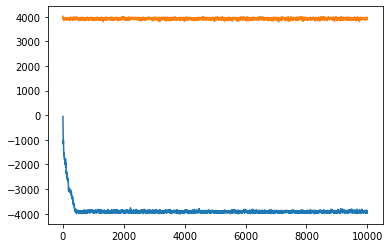

In [247]:
ind = 8
print(T[ind])
plt.plot(dm64[ind])
plt.plot(om64[ind])

1.9000000000000008


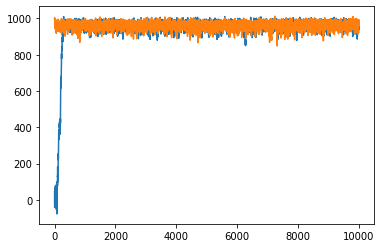

In [232]:
ind = 9
print(T[ind])
plt.plot(dm32[ind])
plt.plot(om32[ind])

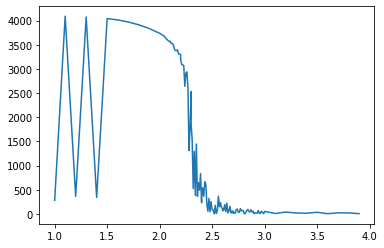

In [238]:
plt.plot(T, [abs(np.average(m[9000:])) for m in dm64])

In [295]:
t = T-2.26918531421

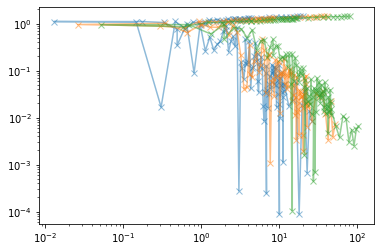

In [291]:
plt.loglog(abs(t)*16, [abs(np.average(m[:1000]))/16/16*np.power(16,1/8) for m in om16],'x-',alpha = 0.5)
plt.loglog(abs(t)*32, [abs(np.average(m[:1000]))/32/32*np.power(16,1/8) for m in om32],'x-',alpha = 0.5)
plt.loglog(abs(t)*64, [abs(np.average(m[:1000]))/64/64*np.power(16,1/8) for m in om64],'x-',alpha = 0.5)
#plt.xlim([1.5,3.5])

(1.5, 3.5)

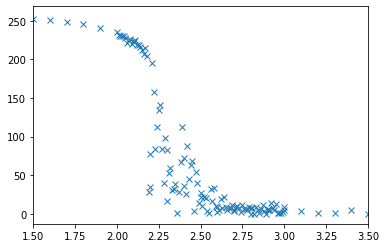

In [166]:
plt.plot(T, [abs(np.average(m[:3000])) for m in om], 'x')
plt.xlim([1.5,3.5])

In [121]:
for i in zeros[0]:
    print(i)

16


In [60]:
T, H = [],[]
dm, dms, de, des, deq = [],[],[],[],[]
om, oms, oe, oes, oeq = [],[],[],[],[]
for key in sim.file:
    t,h = key.split(",")
    t,h = np.array([t,h], np.float64)
    T.append(t)
    H.append(h)
    dm.append(sim.file[key]['Metropolis/disorder']['m'][:])
    dms.append(sim.file[key]['Metropolis/disorder']['ms'][:])
    de.append(sim.file[key]['Metropolis/disorder']['e'][:])
    des.append(sim.file[key]['Metropolis/disorder']['es'][:])
    deq.append(sim.file[key]['Metropolis/disorder']['eq'][:])
    om.append(sim.file[key]['Metropolis/order']['m'][:])
    oms.append(sim.file[key]['Metropolis/order']['ms'][:])
    oe.append(sim.file[key]['Metropolis/order']['e'][:])
    oes.append(sim.file[key]['Metropolis/order']['es'][:])
    oeq.append(sim.file[key]['Metropolis/order']['eq'][:])
    

In [24]:
np.average(m)

0.533

2.0799999999999983


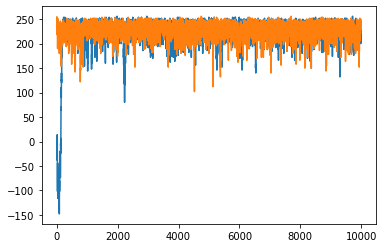

In [177]:
ind = 18
print(T[ind])
plt.plot(dm[ind])
plt.plot(om[ind])

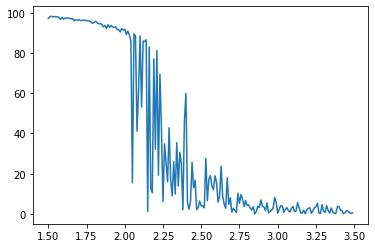

In [64]:
plt.plot(T, [abs(np.average(m)) for m in dm])

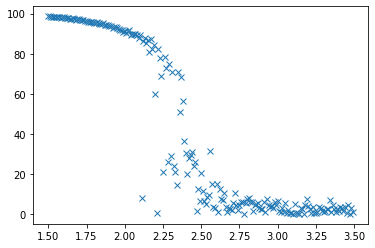

In [71]:
plt.plot(T, [abs(np.average(m[500:])) for m in om],'x')

(2, 3)

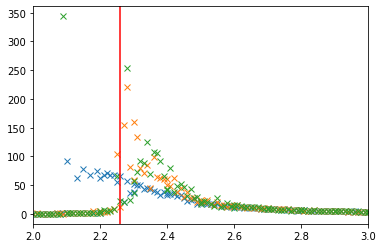

In [268]:
plt.plot(T, [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/16/16 for m,ms,t in zip(om16,oms16,T)],'x')
plt.plot(T, [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/32/32 for m,ms,t in zip(dm32,dms32,T)],'x')
plt.plot(T, [(np.average(ms[4000:]) - np.average(m[4000:])**2)/t/64/64 for m,ms,t in zip(dm64,dms64,T)],'x')
plt.axvline(x=2.26,c='red')
plt.xlim([2,3])

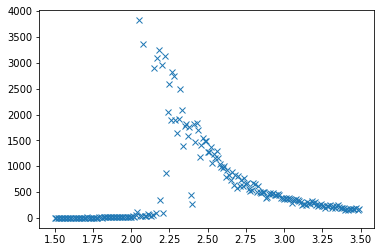

In [73]:
plt.plot(T, [(np.average(ms[500:]) - np.average(m[500:])**2)/t for m,ms,t in zip(dm,dms,T)],'x')

In [279]:
T= np.array(T)

In [281]:
T

array([1.  , 1.1 , 1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.  ,
       2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1 , 2.1 ,
       2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2 , 2.2 ,
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.3 ,
       2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.4 ,
       2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.5 ,
       2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.7 ,
       2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.8 ,
       2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.9 ,
       2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.  ,
       3.1 , 3.2 , 3.3 , 3.4 , 3.5 , 3.6 , 3.7 , 3.8 , 3.9 ])

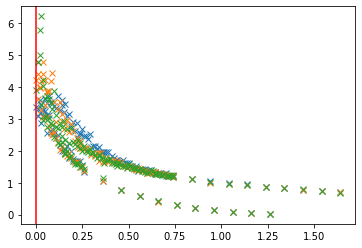

In [293]:
plt.plot(abs(T-Tc), [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/16/16 for m,ms,t in zip(oe16,oes16,T)],'x')
plt.plot(abs(T-Tc), [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/32/32 for m,ms,t in zip(oe32,oes32,T)],'x')
plt.plot(abs(T-Tc), [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/64/64 for m,ms,t in zip(oe64,oes64,T)],'x')
plt.axvline(x=0,c='red')
#plt.xlim([2,3])

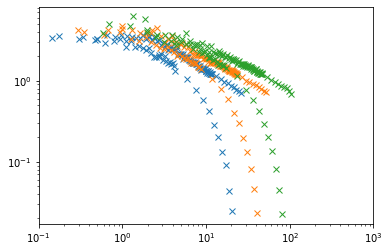

In [357]:
t = T - 2.2691
plt.loglog(abs(t)*16, [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/16/16 for m,ms,t in zip(oe16,oes16,T)],'x')
plt.loglog(abs(t)*32, [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/32/32 for m,ms,t in zip(oe32,oes32,T)],'x')
plt.loglog(abs(t)*64, [(np.average(ms[2000:]) - np.average(m[2000:])**2)/t/64/64 for m,ms,t in zip(oe64,oes64,T)],'x')
plt.xlim([0.1,1000])
plt.axvline(x=0,c='red')
#plt.xlim([2,3])

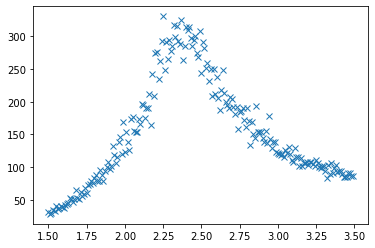

In [75]:
plt.plot(T, [(np.average(ms[500:]) - np.average(m[500:])**2)/t for m,ms,t in zip(oe,oes,T)],'x')

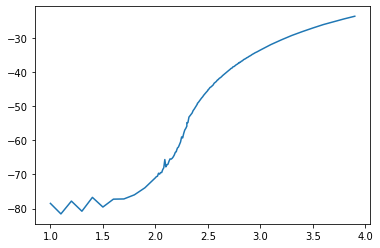

In [258]:
plt.plot(T, [np.average(e)/100 for e in de64])

(2, 3)

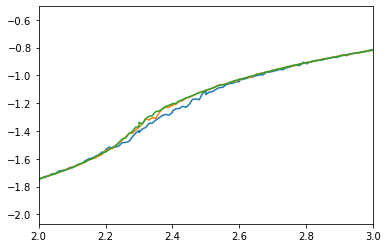

In [261]:
plt.plot(T, [np.average(e)/16/16 for e in oe16])
plt.plot(T, [np.average(e)/32/32 for e in oe32])
plt.plot(T, [np.average(e)/64/64 for e in oe64])
plt.xlim([2,3])

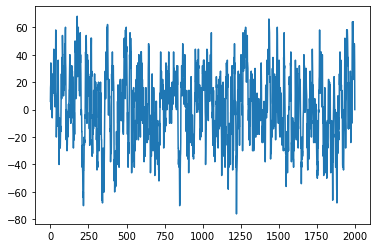

In [77]:
plt.plot((dm[-9]))

In [18]:
T, H = np.array([T,H])